In [25]:
import random
import numpy as np
import json
from tqdm import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
from collections import Counter
import time
import os
import pandas as pd
from scipy.signal import correlate
import matplotlib.pyplot as plt
np. set_printoptions(threshold=np. inf)

In [26]:
# Permanently changes the pandas settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [27]:
date = 'Oct5th-'
filename = ''.join((date,'scan_stats.json'))
filename

'Oct5th-scan_stats.json'

In [28]:
import scan
import simulate_data
palette = simulate_data.create_palette()

In [21]:
params = {
    'M':4,
    'N':100,
    'D':101,
    'T':20000,
    'seed':1,
    'SM_repetitions':2,
    'spikes_in_SM':10,
    'noise':5000
}
M,N,D,T,seed,SM_repetitions,spikes_in_SM,noies = params.values()

In [22]:
A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse = simulate_data.generate_synthetic_data(params,plot=False)

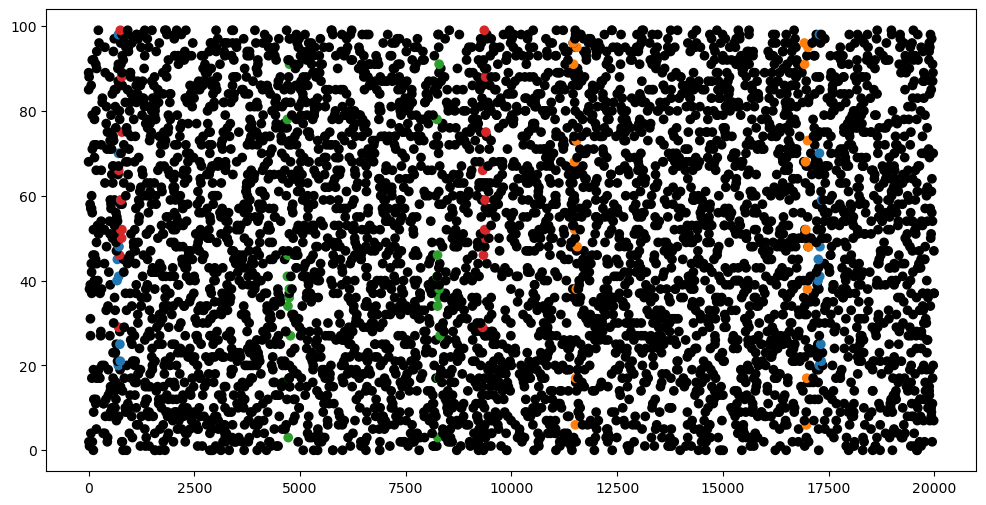

In [23]:
plt.figure(figsize=(12,6))
plt.scatter(A_sparse[1],A_sparse[0],c=palette[A_sparse[2]])

# Script Version

In [24]:
import time
start = time.time()
pattern_template, sublist_keys_filt, window_time, cluster_time, sequence_time = scan.scan_raster(A_sparse[1], A_sparse[0], window_dim=params['D'])
end = time.time()
SM_acc, cc, _ = simulate_data.check_ground_truth(pattern_template, K_dense)
print(SM_acc)


5080 Windows
293 patterns found..... 100%10.01 | opt_cutoff - 1.37 | most_detections - 2etections - 2
[0.90909091 1.         1.         1.        ]


# Notebook Version

## Helper functions

In [23]:
def _get_sim_mats(windows, T_labels, N_labels):
    sim_mats = np.zeros(np.max(N_labels)+1,dtype='object')
    for n in np.unique(N_labels):
        idc = np.where(N_labels==n)[0]
        windows_n = windows[idc]
        if len(windows_n) > 1:
            x = np.zeros((len(windows_n),len(windows_n)))
            for i in range(windows_n.shape[0]):
                for j in range(windows_n.shape[0]):
                    common_rows = windows_n[i].intersection(windows_n[j])
                    num_identical_rows = len(common_rows)
                    x[i,j] = len(common_rows)/min(len(windows_n[i]),len(windows_n[j]))
#             np.fill_diagonal(x,0)# make sure the diagonals are zero, this is important the more spikes there are...
            sim_mats[n] = x-1 
        print(f"Generating sim matrices {round(n*100/np.max(N_labels))}%", end = "\r")
    return sim_mats

def _cluster_windows(cutoff, N_labels, sim_mats):
    clusters = np.zeros_like(N_labels)
    for n in np.unique(N_labels):
        idc = np.where(N_labels==n)[0]
        if (type(sim_mats[n]) == np.ndarray) and (not np.all(sim_mats[n] == 0)):
            l = max(clusters)+1
            clusters[idc]= l+fcluster(linkage(sim_mats[n], method='complete'), cutoff, criterion='distance')
    return clusters

def _check_seq(clusters, T_labels, N_labels):

    time_differences = []
    cluster_sq = {}
    for cluster in np.unique(clusters):
        temp = list(np.diff(np.unique(T_labels[clusters == cluster])))
        str_temp = str(temp)
        time_differences.append(temp)
        if str_temp in cluster_sq.keys():
            cluster_sq[str_temp] = cluster_sq[str_temp] + [cluster]
        else:
            cluster_sq[str_temp] = [cluster]

    # Convert the list of lists to a set of tuples to remove duplicates
    unique_sublists_set = set(tuple(sublist) for sublist in time_differences if sublist)

    # Convert the set of tuples back to a list of lists
    unique_sublists = [list(sublist) for sublist in unique_sublists_set]

    # Count the occurrences of each unique sublist in the original list
    sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)

    # Print the unique sublists and their respective counts
    sq_counts = np.zeros(len(sublist_counts)) 
    for i,sublist in enumerate(unique_sublists):
        count = sublist_counts[tuple(sublist)]
        sq_counts[i] = count
    #     print(f"{sublist}: {count} occurrences")
    sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
    sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron
    sublist_keys_filt = [list(k) for k in sublist_keys_filt]
    
    return cluster_sq, sq_counts, sublist_keys_filt

## Main code

In [24]:
T_labels, N_labels, window_dim = A_sparse[1],A_sparse[0], params['D']

In [25]:
import time
'''
T_labels an array of spiketimes
N_labels corresponding array of neuron labels
window_dim is the size of the window to cluster the spikes
'''
start = time.time()
if window_dim == None:
    window_dim = 100

T_labels = np.round(T_labels).astype(int)
T_labels, N_labels = np.unique(np.array([T_labels,N_labels]),axis=1) # This removes any spikes that occur at the same neuron at the same time
N=max(N_labels)+1

print(f'{len(T_labels)} Windows')
windows = np.zeros((len(T_labels)),dtype='object')
for i,window_time in enumerate(T_labels):
    condition = (T_labels > window_time-window_dim) & (T_labels < window_time + window_dim)
    window = np.array([T_labels[condition]-window_time, N_labels[condition]]).T
    window =  {tuple(row) for row in  window}
    windows[i] = window
    print(f'Windowing... {round(100*i/len(T_labels))}%',end='\r')


max_iter = 50
x = np.arange(0,100)
fun = lambda x,c : x**(1+c)/10**(2*c+1)
list_cutoffs = 0.01 + np.concatenate(((np.arange(0,100)/100)[:15], np.round(fun(x,.8),2)[10:25],np.round(fun(x,.8),2)[25::4],[10]))

opt_cutoff = 0
max_seq_rep = 0
sim_mats = _get_sim_mats(windows, T_labels, N_labels)
end = time.time()
window_time = end-start


print("Clustering...",end="\r")

start = time.time()
for i, cutoff in enumerate(list_cutoffs): 
    clusters = _cluster_windows(cutoff, N_labels, sim_mats)
    cluster_sq, _sq_counts, sublist_keys_filt = _check_seq(clusters, T_labels, N_labels)

    if len(sublist_keys_filt) != 0:
        max_ = np.max([len(k) for k in sublist_keys_filt])
        if max_seq_rep < max_:
            max_seq_rep = max_
            opt_cutoff=cutoff

    print(f'progress - {100*i/max_iter}% | cutoff - {cutoff} | opt_cutoff - {opt_cutoff} | most_detections - {max_seq_rep}',end='\r')

clusters = _cluster_windows(opt_cutoff, N_labels, sim_mats)
cluster_sq, sq_counts, sublist_keys_filt = _check_seq(clusters, T_labels, N_labels)

end = time.time()
cluster_time = end-start

''' to get the timings'''

start = time.time()
# Sort y according to x
sorted_indices = np.argsort(T_labels)
sorted_x = T_labels[sorted_indices]

print("Re-Clustering...",end="\r")

all_times = []
all_labels = []
for key in sublist_keys_filt:
    pattern_repetition_labels = np.zeros((len(cluster_sq[str(key)]),len(clusters)))
    for i,k in enumerate(cluster_sq[str(key)]):
        pattern_repetition_labels[i][clusters==k] = 1
        pattern_repetition_labels[i] *= np.cumsum(pattern_repetition_labels[i])
    pattern_repetition_labels = np.sum(pattern_repetition_labels,axis=0,dtype='int')
    all_labels.append(pattern_repetition_labels)

    sorted_y = pattern_repetition_labels[sorted_indices]
    pattern_times = np.array([sorted_x[sorted_y==i][0] for i in range(1,max(pattern_repetition_labels)+1)])
    all_times.append(pattern_times)

end = time.time()
sequence_time = end-start

print("Extracting templates...",end="\r")

pattern_template = []
patterns = []
for i in range(len(all_times)):
    pattern = []
    pattern_template.append([])
    for time in all_times[i]:
        condition = (T_labels > time-window_dim*2) & (T_labels < time + window_dim*2)
        pattern = [tuple(k) for k in np.array([T_labels[condition]-time, N_labels[condition]]).T] # creating a list of tuples
        pattern_template[-1] += pattern # adds all points of each pattern to template_pattern
        patterns.append(pattern)
    print(f"Extracting templates... {round(100*i/len(all_times))}%",end="\r")

print(f"{len(pattern_template)} patterns found...")

for i,pattern in enumerate(pattern_template):
    counts = [pattern.count(k) for k in pattern]
    pattern_template[i] = np.array(pattern)[np.where(counts == np.max(counts))[0]]
    pattern_template[i][:,0] -= min(pattern_template[i][:,0])
    pattern_template[i] = np.unique(pattern_template[i],axis=0)

1160 Windows
51 patterns found...... 98% 10.01 | opt_cutoff - 1.37 | most_detections - 2etections - 2


### Debugging...

In [13]:
A_sparse[1][A_sparse[0]==2]

array([ 228,  641,  838, 1019, 1518, 1643, 1678, 1759, 1825, 2135, 2440,
       2566, 3546, 3925, 4425, 4847, 4848], dtype=int64)

In [14]:
K_sparse[0],K_sparse[2] # These are the neurons that participate in a spiking motif

(array([ 2,  3,  4,  5,  6,  8, 12, 12, 13, 17, 17, 19, 20, 20, 21, 21, 22,
        25, 27, 28, 28, 29, 29, 31, 33, 34, 35, 36, 36, 38, 38, 40, 41, 41,
        45, 46, 46, 48, 48, 49, 50, 51, 52, 52, 52, 52, 59, 59, 59, 63, 65,
        66, 68, 70, 73, 75, 77, 78, 79, 80, 82, 83, 83, 84, 86, 88, 89, 91,
        91, 92, 93, 93, 94, 95, 95, 95, 96, 98, 98, 99], dtype=int64),
 array([3, 3, 1, 1, 2, 3, 3, 1, 3, 3, 2, 2, 1, 1, 1, 1, 4, 1, 3, 4, 4, 4,
        3, 1, 4, 3, 1, 3, 3, 3, 2, 1, 3, 1, 1, 3, 4, 1, 2, 2, 4, 2, 3, 2,
        4, 4, 2, 4, 1, 4, 4, 4, 2, 1, 2, 4, 1, 3, 2, 2, 3, 4, 2, 3, 2, 4,
        1, 2, 3, 3, 2, 4, 2, 4, 4, 2, 2, 1, 1, 4], dtype=int64))

In [15]:
windows, T_labels, N_labels
sim_mats = np.zeros(np.max(N_labels)+1,dtype='object')
for n in np.unique(N_labels):
    idc = np.where(N_labels==n)[0]
    windows_n = windows[idc]
    if len(windows_n) > 1:
        x = np.zeros((len(windows_n),len(windows_n)))
        for i in range(windows_n.shape[0]):
            for j in range(windows_n.shape[0]):
                common_rows = windows_n[i].intersection(windows_n[j])
                num_identical_rows = len(common_rows)
                x[i,j] = len(common_rows)/min(len(windows_n[i]),len(windows_n[j]))
#             np.fill_diagonal(x,0)# make sure the diagonals are zero, this is important the more spikes there are...
        sim_mats[n] = x-1 
    print(f"Generating sim matrices {round(n*100/np.max(N_labels))}%", end = "\r")


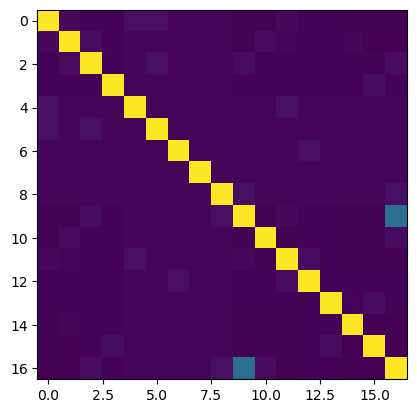

In [16]:
%matplotlib inline
plt.figure()
plt.imshow(sim_mats[2]) # This looks right because there is only 1 repeat of this pattern...

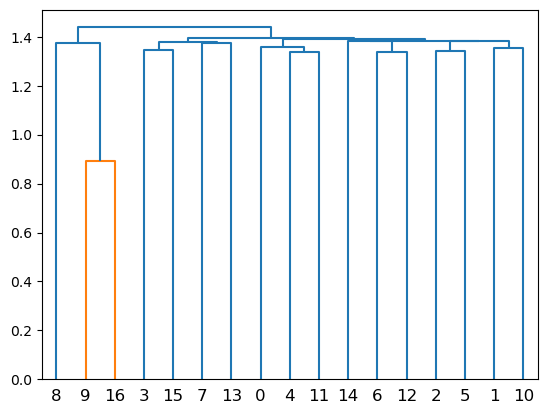

In [17]:
plt.figure()
dn = dendrogram(linkage(sim_mats[2],method='complete',optimal_ordering=False))
plt.show()